In [10]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import re
import os
from os import path
import sys
import time

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [34]:
LINUX_COLS = ['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7', 'joules', 'timestamp']

#2600000
#TIME_CONVERSION_khz = 1./(2899999*1000
TIME_CONVERSION_khz = 1./(2600000*1000)
JOULE_CONVERSION = 0.00001526

dvfs_list = ['0c00', '0d00', '0e00', 
             '0f00', '1000', '1100', '1200', 
             '1300', '1400', '1500', '1600', '1700', '1800', '1900', '1a00']
dvfs_dict = {
    "0x0c00" :  1.2,
    "0x0d00" :  1.3,
    "0x0e00" :  1.4,
    "0x0f00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
}

df_dict = {
    'i': [], 'itr': [], 'dvfs': [], 'rate': [], 'policy': [], 'watts_avg': [], 'watts_std': [], 
    
    'pollCnt': [], 'c1Cnt': [], 'c1eCnt': [],'c3Cnt': [], 'c6Cnt': [], 
    'rxPackets': [], 'rxBytes': [], 'txPackets': [], 'txBytes': [],
    'erxPackets': [], 'erxBytes':[], 'etxPackets': [], 'etxBytes':[],
    
    'SinknumRecordsInPerSecond_avg': [], 'SinknumRecordsInPerSecond_std': [], 
    'SinknumRecordsOutPerSecond_avg': [], 'SinknumRecordsOutPerSecond_std': [], 
    'SinkbusyTimeMsPerSecond_avg': [], 'SinkbusyTimeMsPerSecond_std': [], 
    'SinkbackPressuredTimeMsPerSecond_avg': [], 'SinkbackPressuredTimeMsPerSecond_std': [], 
    'SinkbusyTime_%': [], 'SinkbackPressuredTime_%': [], 

    'SourcenumRecordsInPerSecond_avg': [], 'SourcenumRecordsInPerSecond_std': [], 
    'SourcenumRecordsOutPerSecond_avg': [], 'SourcenumRecordsOutPerSecond_std': [], 
    'SourcebusyTimeMsPerSecond_avg': [], 'SourcebusyTimeMsPerSecond_std': [], 
    'SourcebackPressuredTimeMsPerSecond_avg': [], 'SourcebackPressuredTimeMsPerSecond_std': [], 
    'SourcebusyTime_%': [], 'SourcebackPressuredTime_%': [], 

    'MappernumRecordsInPerSecond_avg': [], 
    'MappernumRecordsInPerSecond_std': [], 'MappernumRecordsOutPerSecond_avg': [], 
    'MappernumRecordsOutPerSecond_std': [], 'MapperbusyTimeMsPerSecond_avg': [], 
    'MapperbusyTimeMsPerSecond_std': [], 'MapperbackPressuredTimeMsPerSecond_avg': [], 
    'MapperbackPressuredTimeMsPerSecond_std': [],
    'MapperbusyTime_%': [], 'MapperbackPressuredTime_%': []
}

print(df_dict)
print("*****************************************************************")

def resetdf():
    global df_dict
    df_dict = {
    'i': [], 'itr': [], 'dvfs': [], 'rate': [], 'policy': [],
    
    'pollCnt': [], 'c1Cnt': [], 'c1eCnt': [],'c3Cnt': [], 'c6Cnt': [], 
    'rxPackets': [], 'rxBytes': [], 'txPackets': [], 'txBytes': [],
    'erxPackets': [], 'erxBytes':[], 'etxPackets': [], 'etxBytes':[],
    
    'SinknumRecordsInPerSecond_avg': [], 'SinknumRecordsInPerSecond_std': [], 
    'SinknumRecordsOutPerSecond_avg': [], 'SinknumRecordsOutPerSecond_std': [], 
    'SinkbusyTimeMsPerSecond_avg': [], 'SinkbusyTimeMsPerSecond_std': [], 
    'SinkbackPressuredTimeMsPerSecond_avg': [], 'SinkbackPressuredTimeMsPerSecond_std': [], 
    'SinkbusyTime_%': [], 'SinkbackPressuredTime_%': [], 

    'SourcenumRecordsInPerSecond_avg': [], 'SourcenumRecordsInPerSecond_std': [], 
    'SourcenumRecordsOutPerSecond_avg': [], 'SourcenumRecordsOutPerSecond_std': [], 
    'SourcebusyTimeMsPerSecond_avg': [], 'SourcebusyTimeMsPerSecond_std': [], 
    'SourcebackPressuredTimeMsPerSecond_avg': [], 'SourcebackPressuredTimeMsPerSecond_std': [], 
    'SourcebusyTime_%': [], 'SourcebackPressuredTime_%': [], 

    'MappernumRecordsInPerSecond_avg': [], 
    'MappernumRecordsInPerSecond_std': [], 'MappernumRecordsOutPerSecond_avg': [], 
    'MappernumRecordsOutPerSecond_std': [], 'MapperbusyTimeMsPerSecond_avg': [], 
    'MapperbusyTimeMsPerSecond_std': [], 'MapperbackPressuredTimeMsPerSecond_avg': [], 
    'MapperbackPressuredTimeMsPerSecond_std': [],
    'MapperbusyTime_%': [], 'MapperbackPressuredTime_%': []
    }
    
def parseFile(loc, rate, itr, dvfs, policy, i):
    file=f"{loc}/summary.csv"
    #print(file)
    df_dict['i'].append(i)
    df_dict['itr'].append(itr)
    #if '0x'+dvfs in dvfs_dict:
    #    df_dict['dvfs'].append(dvfs_dict['0x'+dvfs])
    #else:
    df_dict['dvfs'].append(dvfs)
    df_dict['policy'].append(policy)
    df_dict['rate'].append(rate)
        
    df = pd.read_csv(file)
    df = df[df.columns.drop(list(df.filter(regex='Cnt')))]
    df = df[df.columns.drop(list(df.filter(regex='Bytes')))]
    #print(df)
    
    dff = df[df['name'].str.contains('Sink')]
    dff.columns = 'Sink' + dff.columns
    cols = dff.columns
    for col in cols[2:]:
        df_dict[col].append(dff.mean(numeric_only=True)[col])

    dff = df[df['name'].str.contains('Source')]
    dff.columns = 'Source' + dff.columns
    cols = dff.columns
    for col in cols[2:]:
        df_dict[col].append(dff.mean(numeric_only=True)[col])

    dff = df[df['name'].str.contains('Mapper')]
    dff.columns = 'Mapper' + dff.columns
    cols = dff.columns
    for col in cols[2:]:
        df_dict[col].append(dff.mean(numeric_only=True)[col])

    #jfile = f"{loc}/server2_rapl.log"
    #with open(jfile) as file:
    #    lines = [float(line.rstrip()) for line in file]
    #    print(len(lines))
    #    df_dict['watts_avg'].append(float(round(np.mean(lines[300:600]), 2)))
    #    df_dict['watts_std'].append(float(round(np.std(lines[300:600]), 2)))
        #print(np.std(lines[300:500]))
        
    jfile = f"{loc}/stats.csv"
    with open(jfile) as file:
        poll = []
        c1 = []
        c1e = []
        c3 = []
        c6 = []
        rxp = []
        rxb = []
        txp = []
        txb = []
        erxp = []
        erxb = []
        etxp = []
        etxb = []
        for line in file:
            ll = [int(a) for a in line.strip().split(',')]
            poll.append(ll[0])
            c1.append(ll[1])
            c1e.append(ll[2])
            c3.append(ll[3])
            c6.append(ll[4])
            rxp.append(ll[5])
            rxb.append(ll[6])
            txp.append(ll[7])
            txb.append(ll[8])
            erxp.append(ll[9])
            erxb.append(ll[10])
            etxp.append(ll[11])
            etxb.append(ll[12])
        ss = 30
        ee = 60
        df_dict['pollCnt'].append(np.sum(poll[ss:ee]))
        df_dict['c1Cnt'].append(np.sum(c1[ss:ee]))
        df_dict['c1eCnt'].append(np.sum(c1e[ss:ee]))
        df_dict['c3Cnt'].append(np.sum(c3[ss:ee]))
        df_dict['c6Cnt'].append(np.sum(c6[ss:ee]))
        #'rxPackets': [], 'rxBytes': [], 'txPackets': [], 'txBytes': [],
        df_dict['rxPackets'].append(np.sum(rxp[ss:ee]))
        df_dict['rxBytes'].append(np.sum(rxb[ss:ee]))        
        df_dict['txPackets'].append(np.sum(txp[ss:ee]))
        df_dict['txBytes'].append(np.sum(txb[ss:ee]))
        df_dict['erxPackets'].append(np.sum(erxp[ss:ee]))
        df_dict['erxBytes'].append(np.sum(erxb[ss:ee]))
        #print(np.mean(erxb[30:50]), np.std(erxb[30:50]))
        df_dict['etxPackets'].append(np.sum(etxb[ss:ee]))
        df_dict['etxBytes'].append(np.sum(etxb[ss:ee]))

{'i': [], 'itr': [], 'dvfs': [], 'rate': [], 'policy': [], 'watts_avg': [], 'watts_std': [], 'pollCnt': [], 'c1Cnt': [], 'c1eCnt': [], 'c3Cnt': [], 'c6Cnt': [], 'rxPackets': [], 'rxBytes': [], 'txPackets': [], 'txBytes': [], 'erxPackets': [], 'erxBytes': [], 'etxPackets': [], 'etxBytes': [], 'SinknumRecordsInPerSecond_avg': [], 'SinknumRecordsInPerSecond_std': [], 'SinknumRecordsOutPerSecond_avg': [], 'SinknumRecordsOutPerSecond_std': [], 'SinkbusyTimeMsPerSecond_avg': [], 'SinkbusyTimeMsPerSecond_std': [], 'SinkbackPressuredTimeMsPerSecond_avg': [], 'SinkbackPressuredTimeMsPerSecond_std': [], 'SinkbusyTime_%': [], 'SinkbackPressuredTime_%': [], 'SourcenumRecordsInPerSecond_avg': [], 'SourcenumRecordsInPerSecond_std': [], 'SourcenumRecordsOutPerSecond_avg': [], 'SourcenumRecordsOutPerSecond_std': [], 'SourcebusyTimeMsPerSecond_avg': [], 'SourcebusyTimeMsPerSecond_std': [], 'SourcebackPressuredTimeMsPerSecond_avg': [], 'SourcebackPressuredTimeMsPerSecond_std': [], 'SourcebusyTime_%': []


200000 0 mean=68.16860040333333 max=80.026611 min=64.643082 std=1.8501889081461225
200000 1 mean=71.41180965 max=81.41864 min=66.247177 std=2.624640973351504
200000 2 mean=73.15902939666667 max=82.215073 min=69.250336 std=1.6319400031231106
200000 3 mean=71.43329153333335 max=78.738876 min=66.895798 std=1.7326460066289446
200000 4 mean=69.58317930333334 max=77.222061 min=65.13826 std=1.6917536304117937
200000 5 mean=72.77063651333333 max=80.624374 min=69.116272 std=1.6898551227137555
200000 6 mean=73.35223370333333 max=80.673843 min=69.622299 std=1.682618021131093
200000 7 mean=73.73784022666666 max=80.556961 min=69.182022 std=1.6230390479346235
200000 8 mean=72.41782746333332 max=79.174698 min=68.696884 std=1.6008051080661747
200000 9 mean=73.05043846666666 max=79.993362 min=68.890945 std=1.729109561675476

200000 0 mean=66.65823970666666 max=74.454987 min=61.691299 std=1.7672641036240533
200000 1 mean=77.0984276 max=82.340912 min=73.704315 std=1.3747113622430156
200000 2 mean=72.780

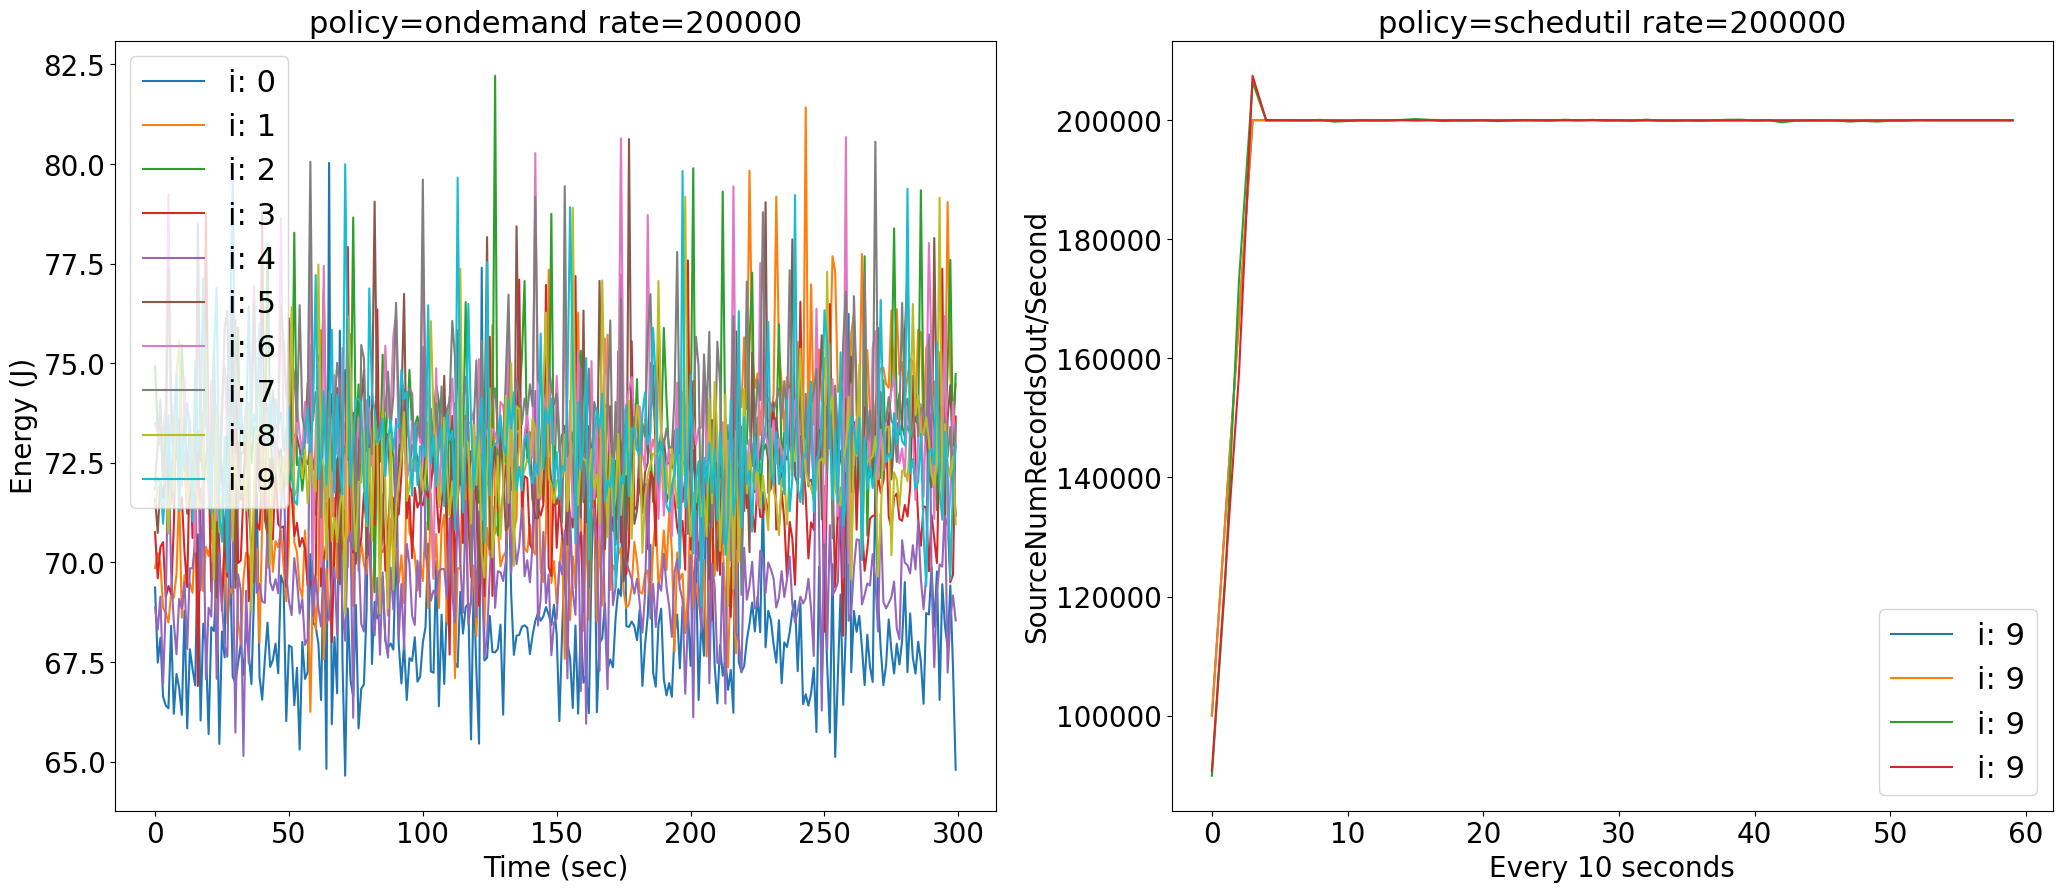

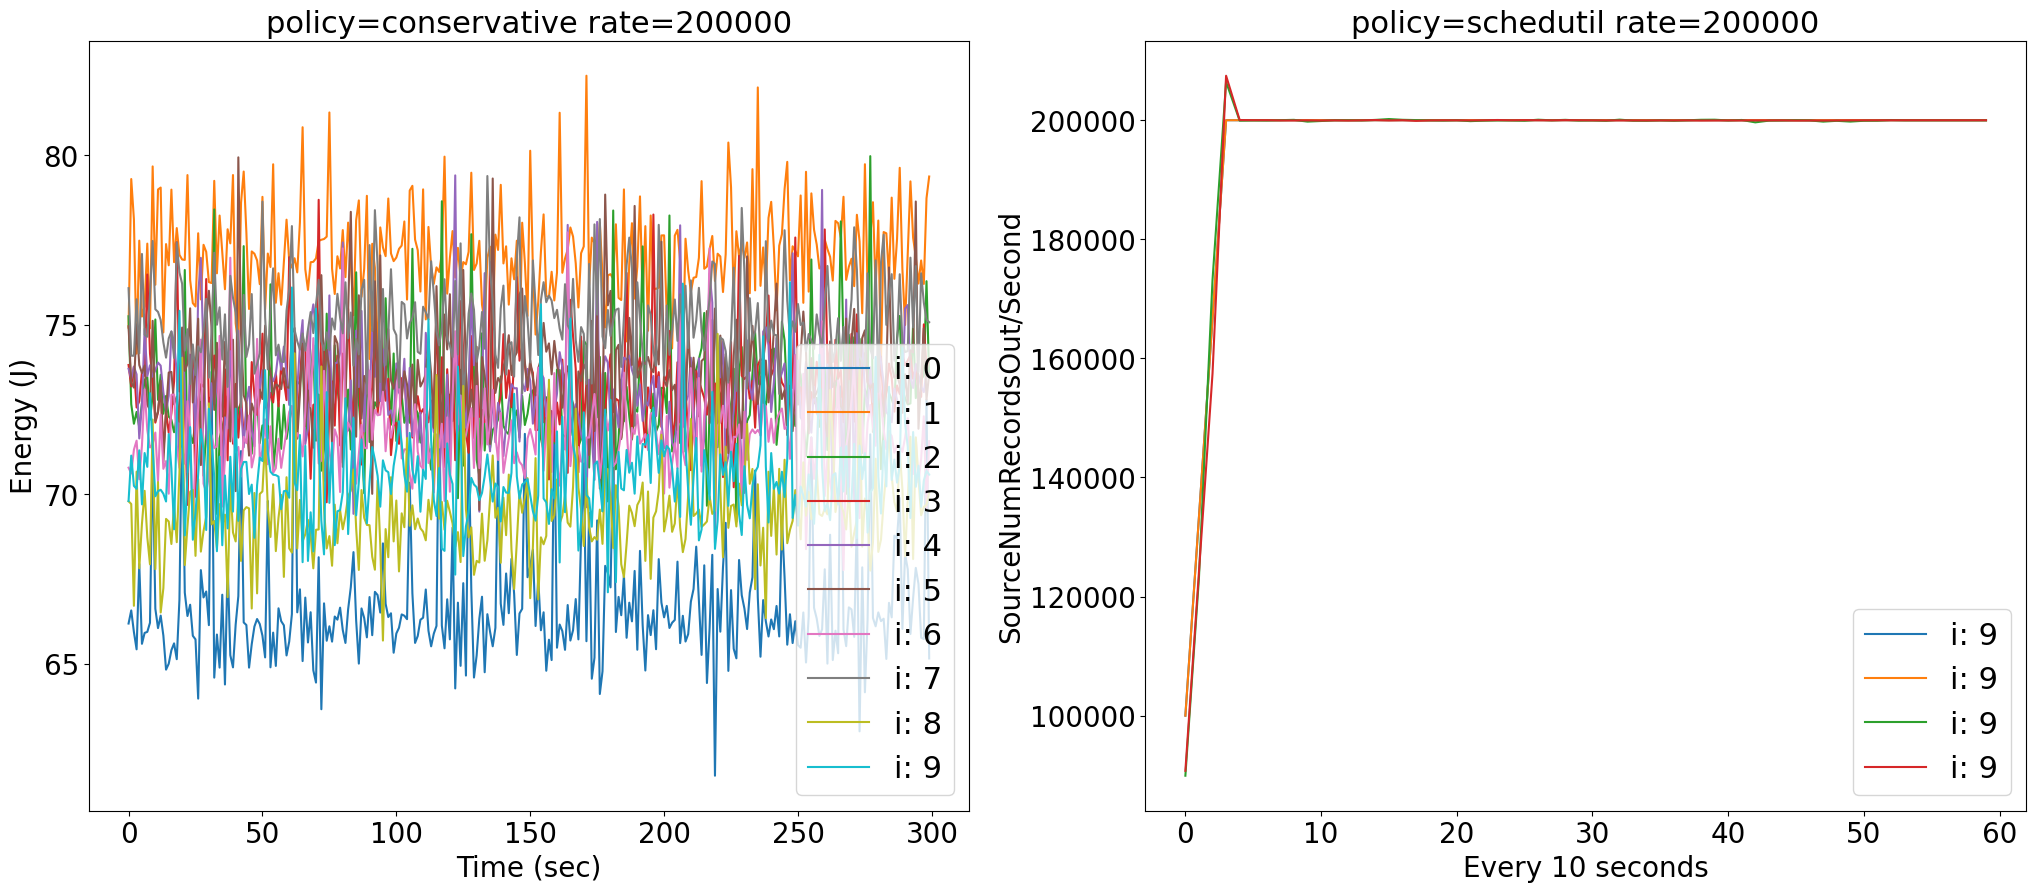

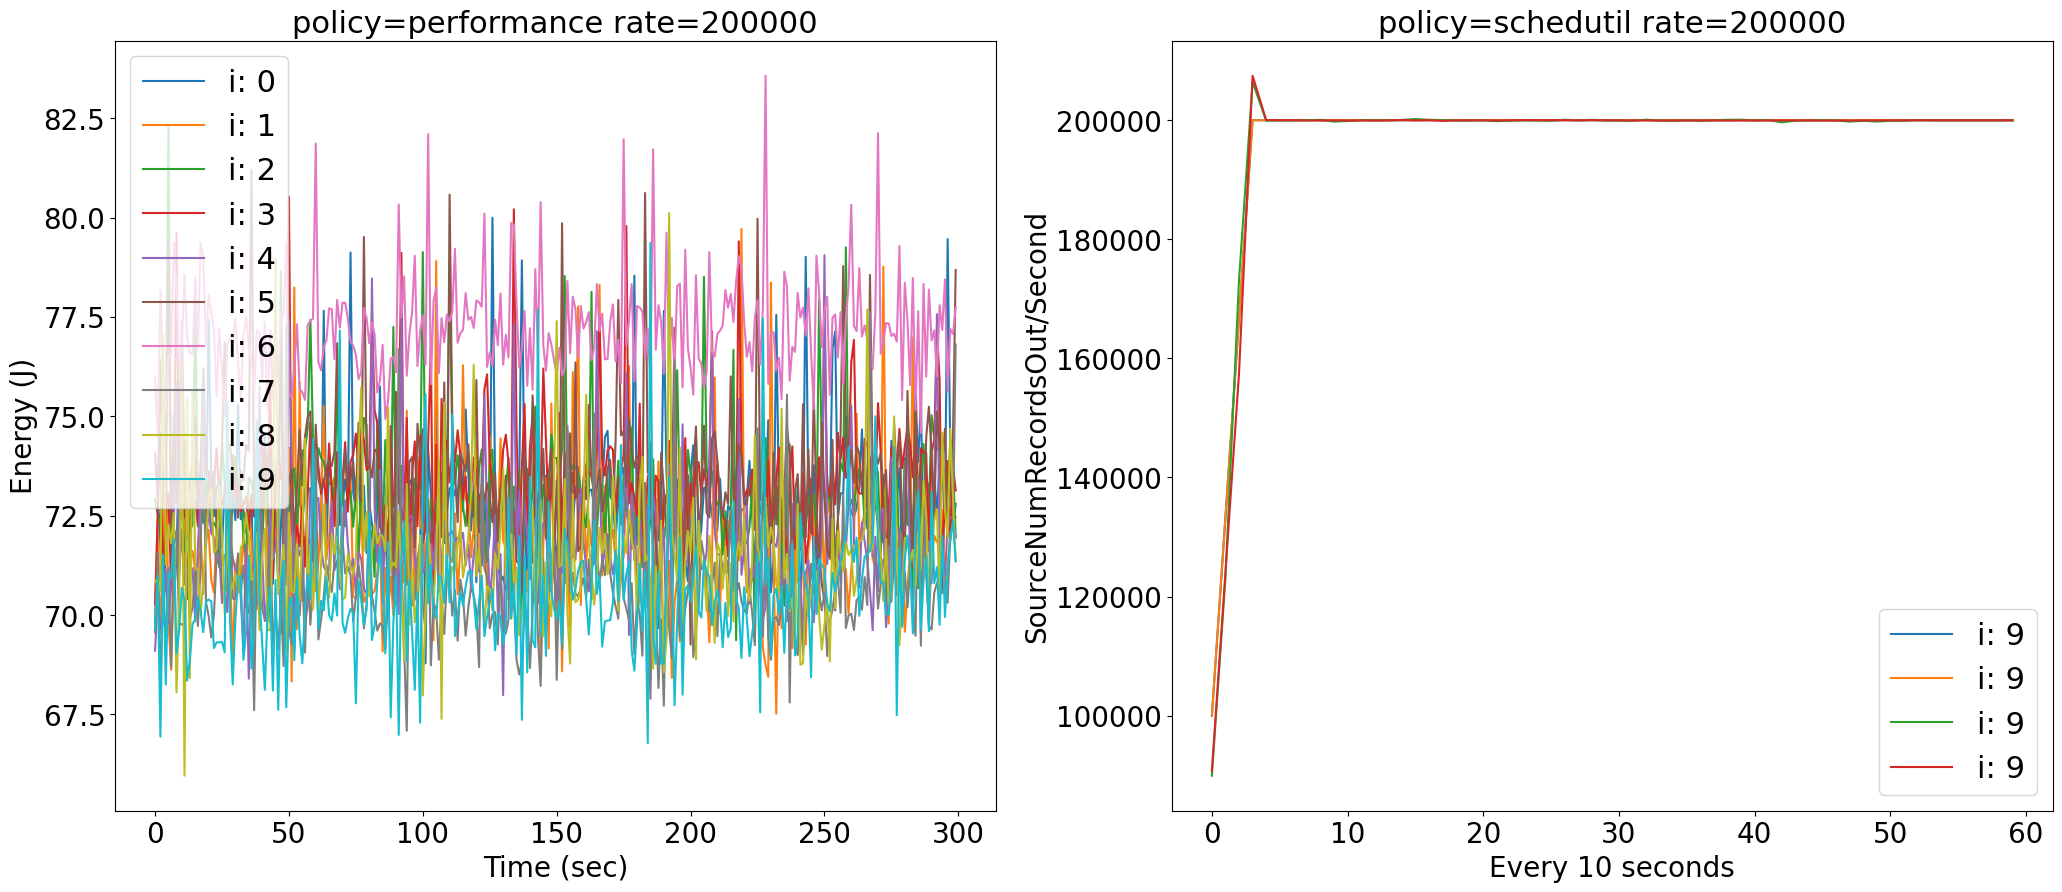

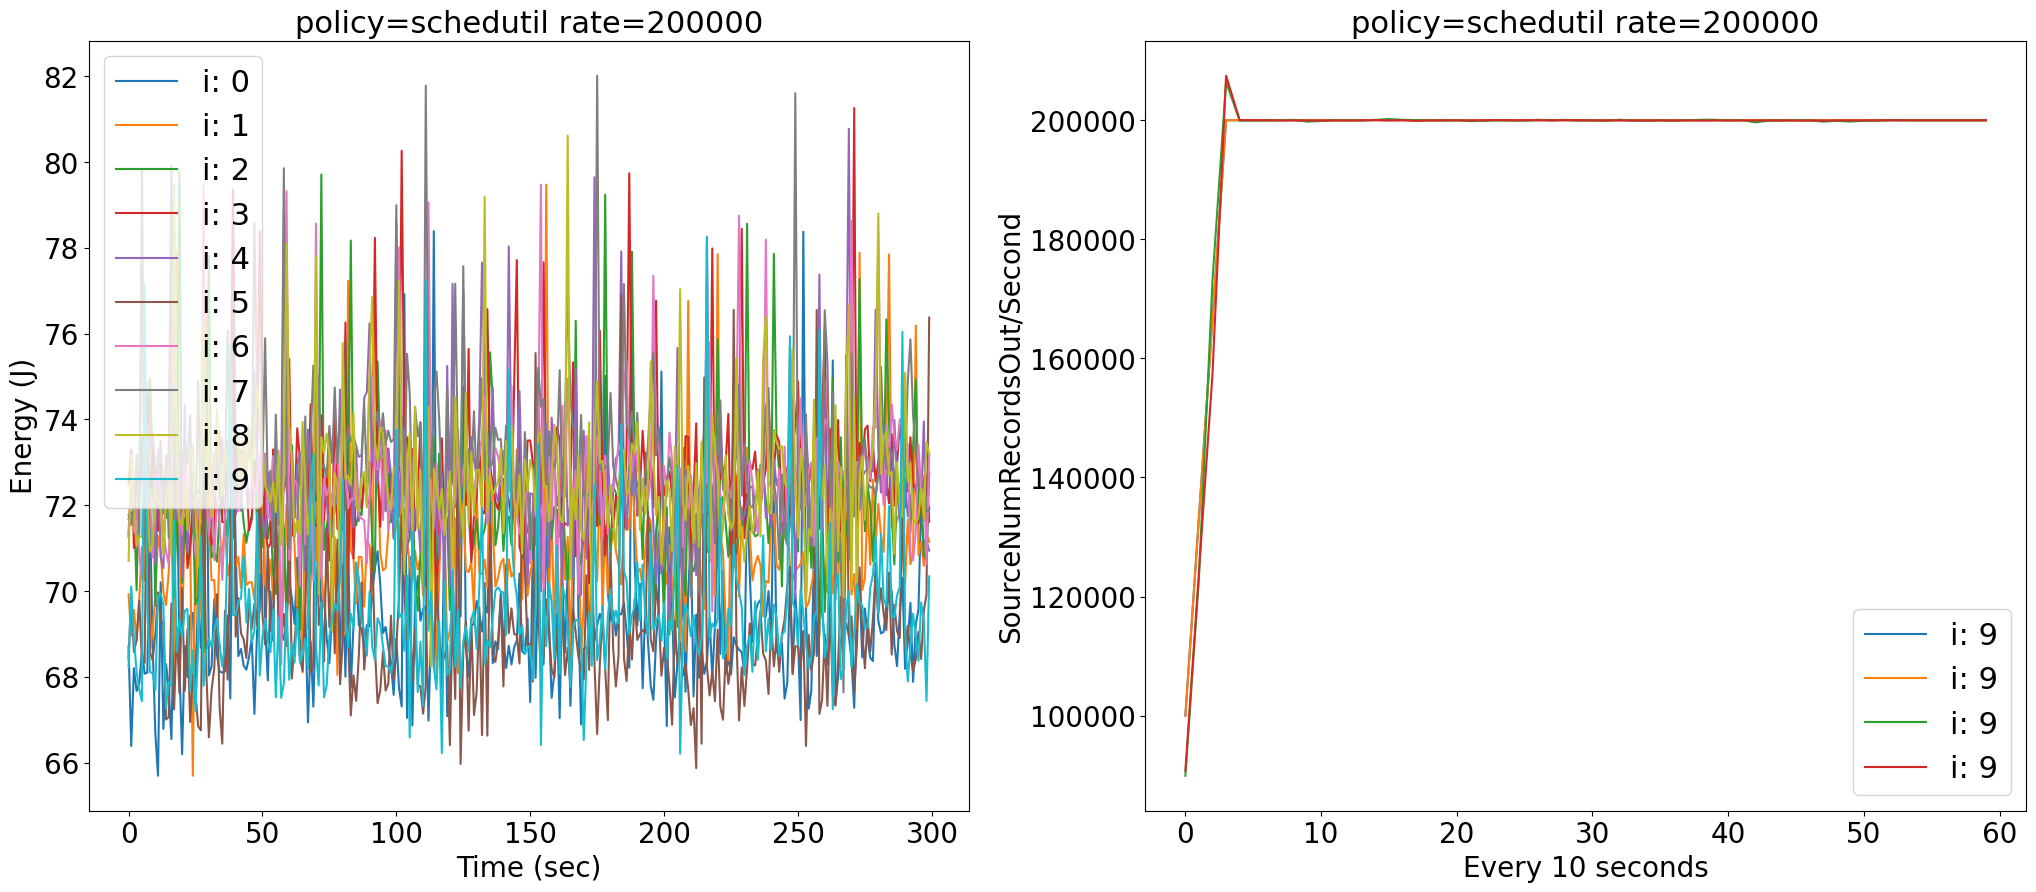

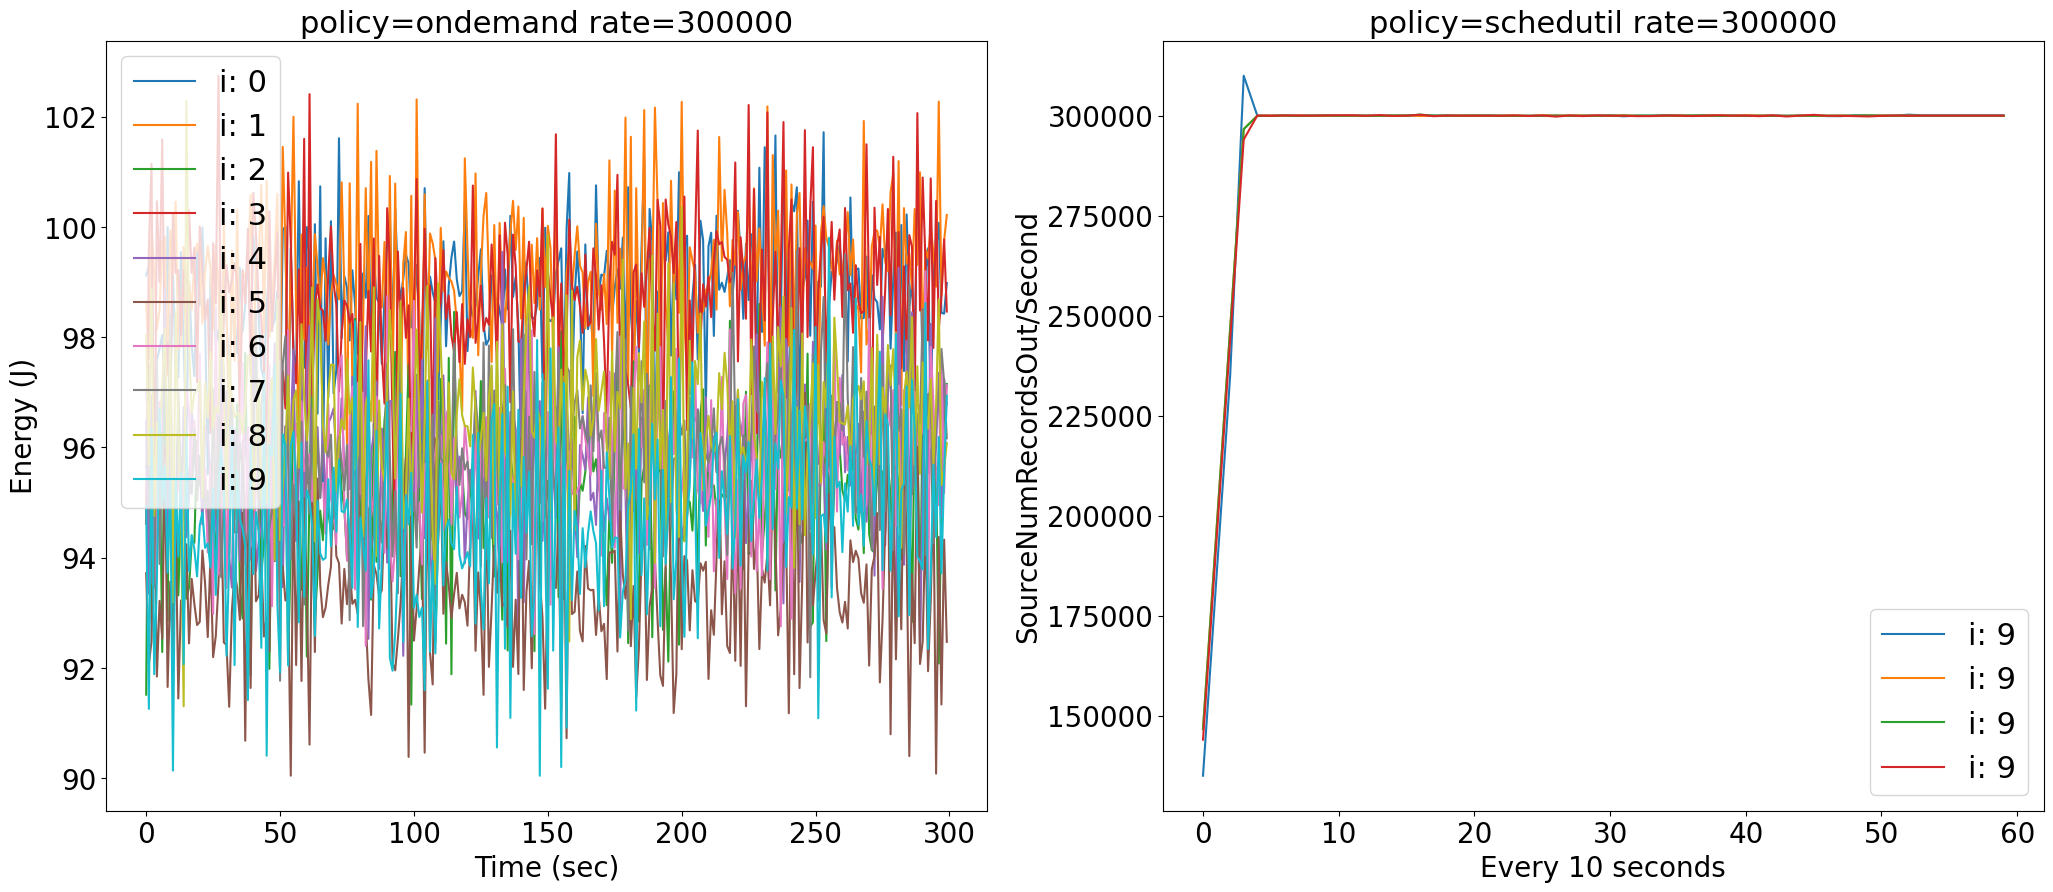

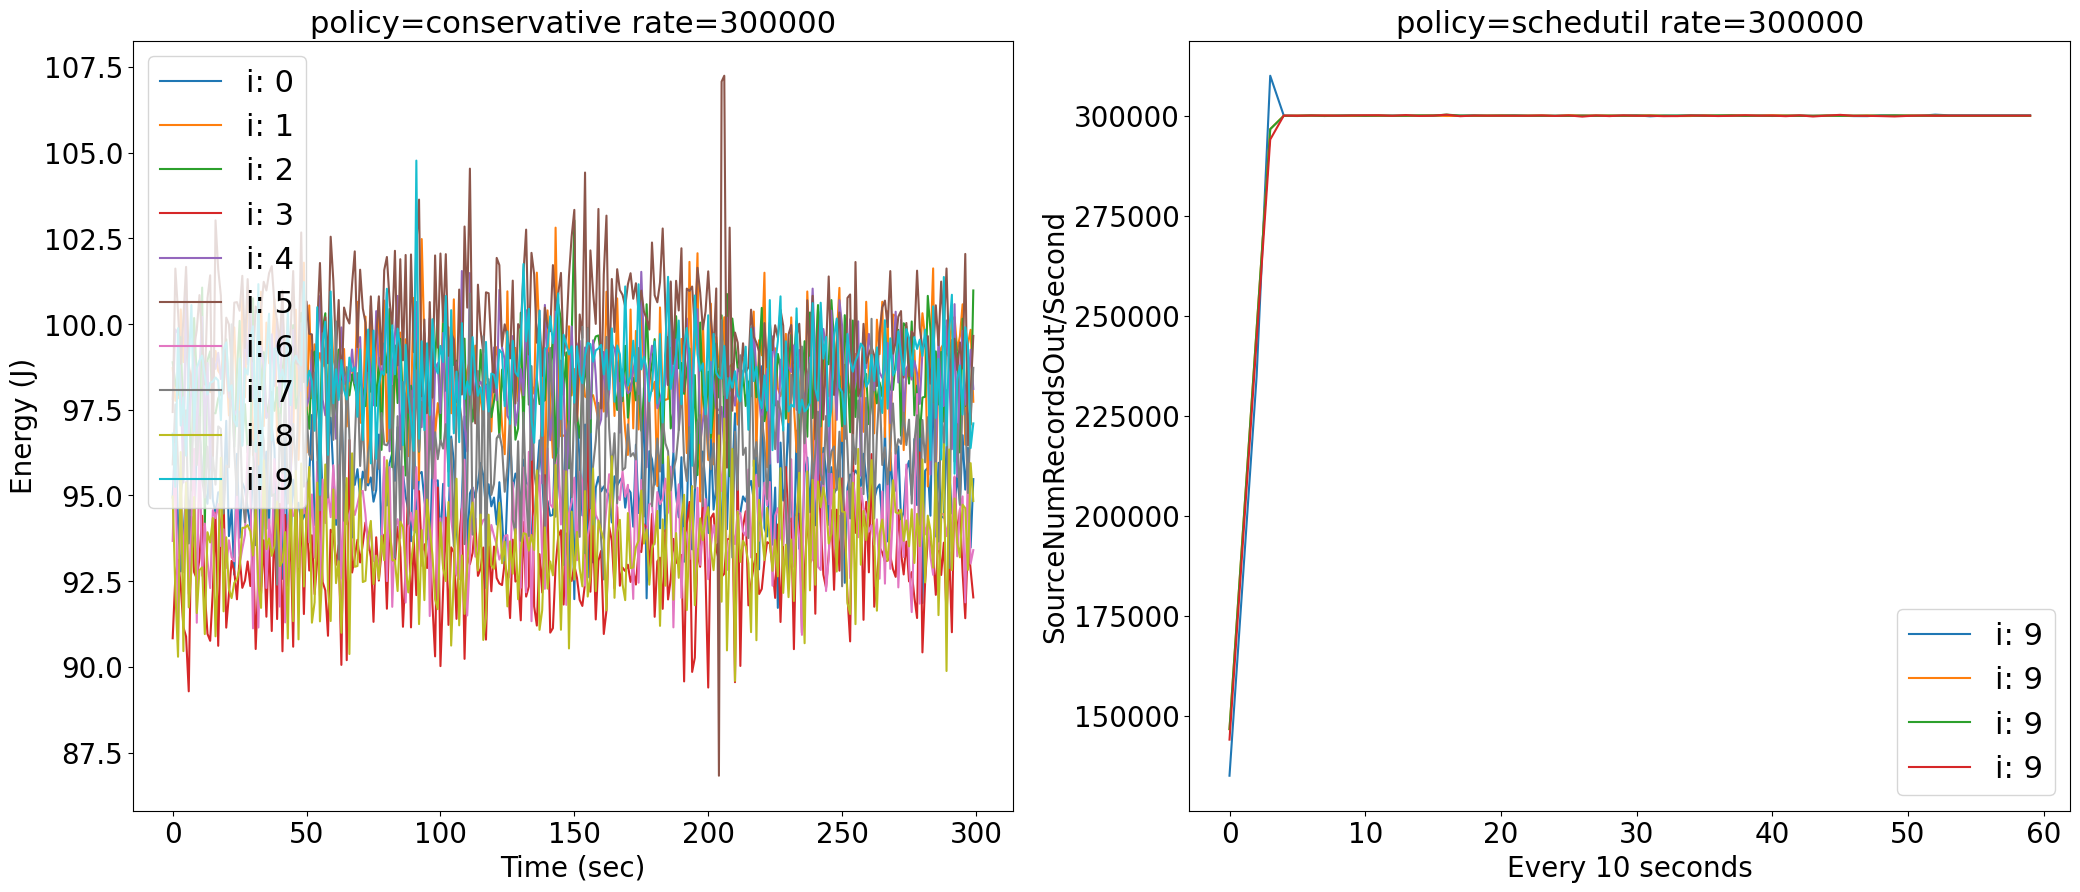

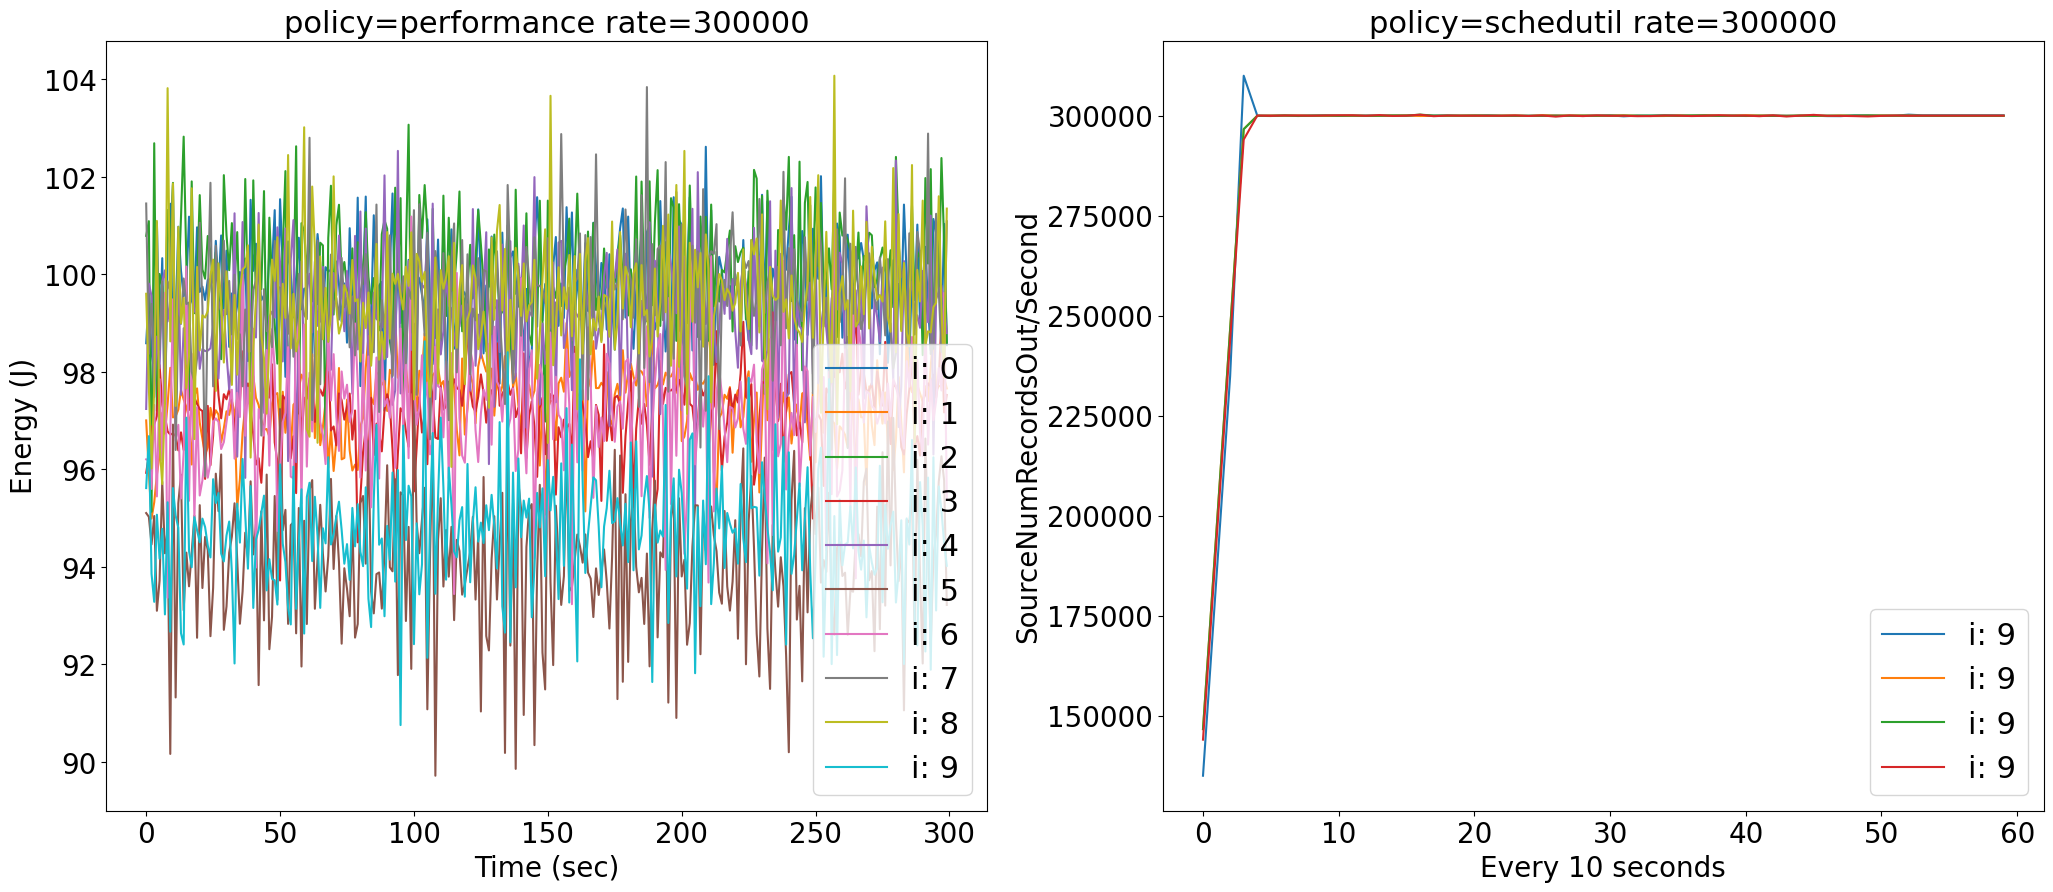

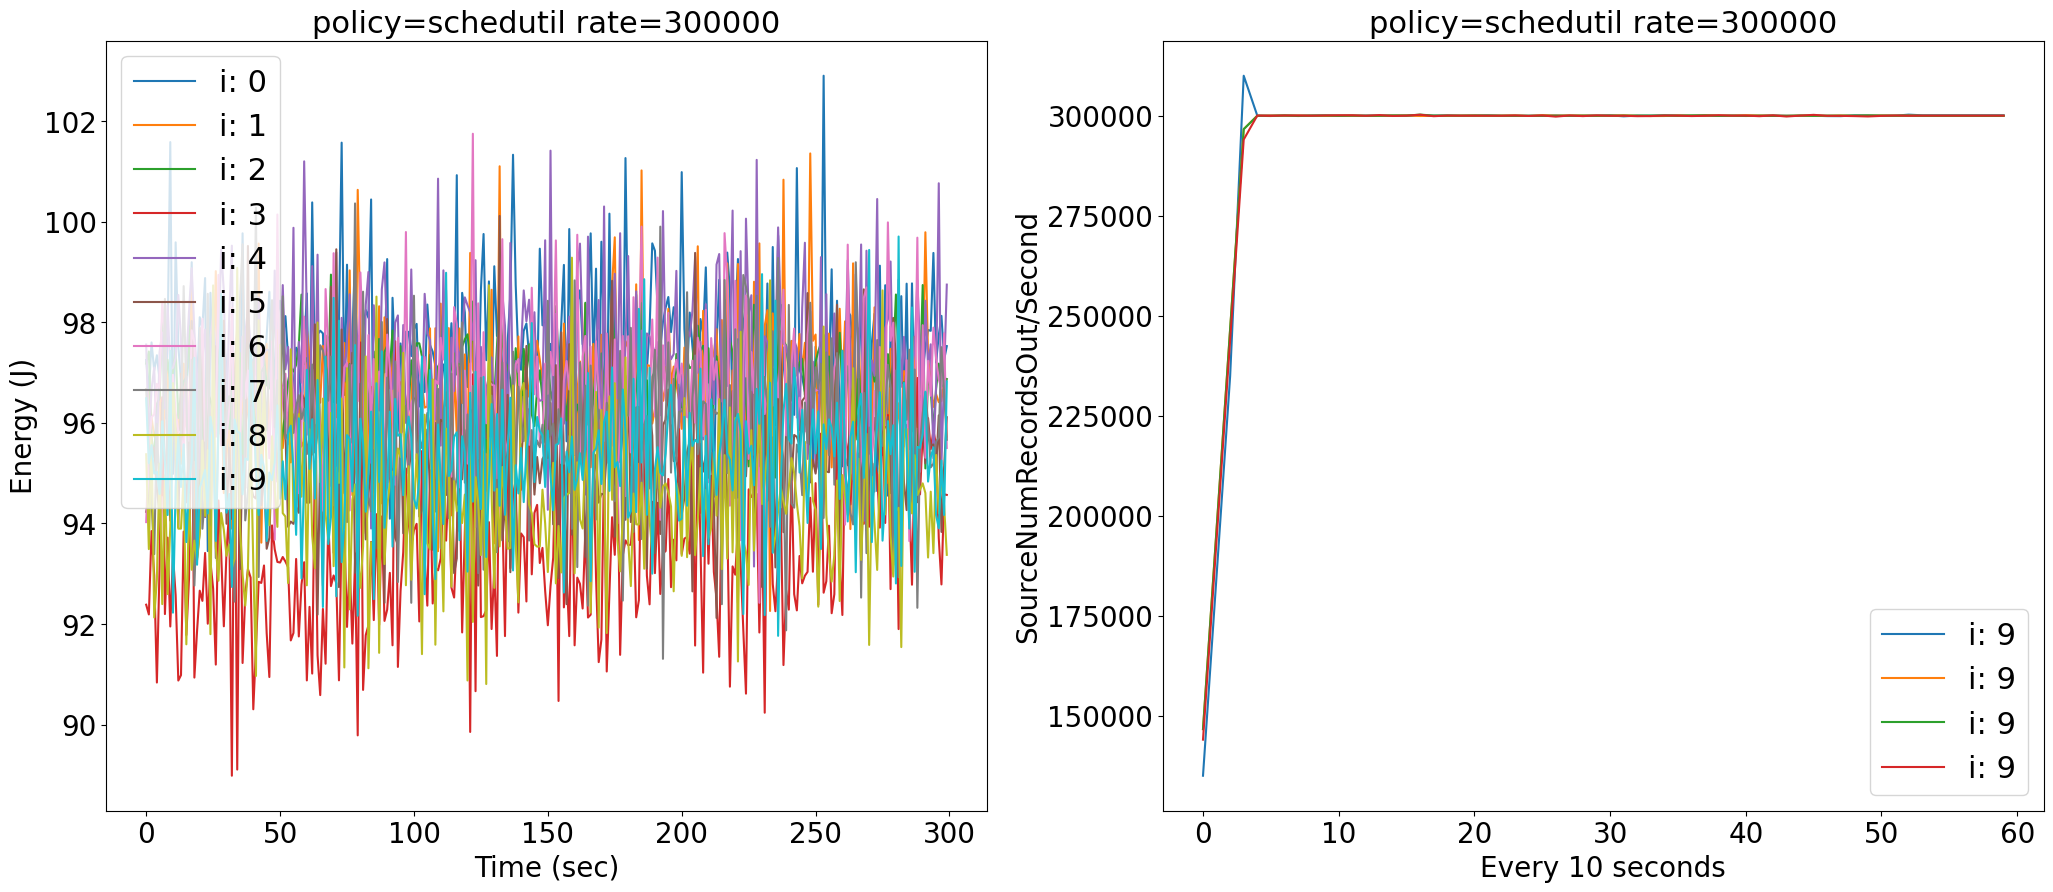

In [12]:
itr=1
dvfs=1
nrepeat = 10
policies = ["ondemand", "conservative","performance", "schedutil"]
#policies = ["ondemand"]

plt.rcParams['figure.figsize'] = 25, 10
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

for rate in [200000, 300000]:
    for policy in policies:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        print("")
        for i in range(nrepeat):    
            #plt.subplots_adjust(wspace=5, hspace=0)
        
            if policy == "dvfspolicy1":
                file=f"/home/han/tmp/cl/experiment-scripts/logs/query1_cores16_frate{rate}_600000_fbuff-1_{policy}_repeat{i}/server2_rapl.log"
            else:
                file=f"/home/han/github/logs/10_10_2023_5.15.89_itrlog/query1_cores16_frate{rate}_600000_fbuff-1_itr{itr}_{policy}dvfs{dvfs}_repeat{i}/server2_rapl.log"
            with open(file, "r") as f:
                y = [float(x.strip()) for x in f.readlines()]
            y = y[300:600]
            print(f"{rate} {i} mean={np.mean(y)} max={np.max(y)} min={np.min(y)} std={np.std(y)}")
            ax1.errorbar(range(len(y)), y, label=f"i: {i}")
        #ax1.set_ylim(bottom=50)
        ax1.set_ylabel("Energy (J)")
        ax1.set_xlabel("Time (sec)")
        #ax1.set_yscale("log") 
        ax1.legend(fontsize=22)
        ax1.set_title(f"policy={policy} rate={rate}", fontsize=22)
        
        #print(df)
        #for policy in ["ondemand"]:
        for policy in policies:
            colnames = []
            for cnt in range(0, 60):
                colnames.append(f"col{cnt}")
            df = pd.DataFrame(columns=colnames)
            if policy == "dvfspolicy1":
                ddir=f"/home/han/tmp/cl/experiment-scripts/logs/query1_cores16_frate{rate}_600000_fbuff-1_{policy}_repeat{i}/Flinklogs/"
            else:
                ddir=f"/home/han/github/logs/10_10_2023_5.15.89_itrlog/query1_cores16_frate{rate}_600000_fbuff-1_itr{itr}_{policy}dvfs{dvfs}_repeat{i}/Flinklogs/"
            for sr in range(0,14):
                #print(sr)
                ff=open(ddir+"Operator_Source: Bids Source_"+str(sr), 'r').readlines()
                srcs = []
                for _ll, _lc in enumerate(ff):
                    for lc in _lc.split('; '):
                        if "numRecordsOutPerSecond" in lc:
                            ldict=eval(lc.replace('[','').replace(']',''))
                            srcs.append(float(ldict['value']))
                if len(srcs) ==  59:
                        srcs.insert(0, 0)                
                df.loc[-1] = srcs
                df.index = df.index + 1  # shifting index
        #print(df)
            df2 = df.mean(axis=0)
            y = df2.tolist()
            ax2.errorbar(range(len(y)), y, label=f"i: {i}")
            
        
        ax2.set_ylabel("SourceNumRecordsOut/Second")
        #ax2.set_ylabel("backPressuredTimeMsPerSecond")
        ax2.set_xlabel("Every 10 seconds")
        ax2.legend(fontsize=22)
        ax2.set_title(f"policy={policy} rate={rate}", fontsize=22)
        #df2.plot()                
        
#300000 0 mean=96.41935393666667 max=99.609772 min=92.902618 std=1.1247896345050448
#300000 1 mean=91.28728946666666 max=103.793915 min=76.622223 std=1.7120520983173737
#300000 2 mean=102.88998121666667 max=107.462189 min=98.031693 std=1.2708486772790886

In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#print(f"linux_tuned {i} {policy} {round(tjoules /(298.0), 2)} {trx_desc} {trx_bytes} {ttx_desc} {ttx_bytes} {tins} {tcyc} {trefcyc} {tllcm} {tnum_interrupts} {ttimestamp}")
df_dict2 = {
    'i': [], 'itr': [], 'dvfs': [], 'rate': [], 'policy': [], 'joules': [],    
    'rxDescIntLog': [], 'rxBytesIntLog': [], 'txDescIntLog': [], 'txBytesIntLog': [],
    'instructions': [], 'cycles': [], 
    'ref_cycles': [], 'llc_miss': [], 
    'num_interrupts': [], 'time': []
}


mqps = 0
cqps = 0
tins = 0
tcyc = 0
trefcyc = 0
tllcm = 0
tc3 = 0
tc6 = 0
tc7 = 0
tc1 = 0
tc1e = 0
trx_desc = 0
trx_bytes = 0
ttx_desc = 0
ttx_bytes = 0
tjoules = 0.0
tnum_interrupts = 0
ttimestamp = 0
#itr = re.findall(r'itr\s*(\d+)', loc)
#dvfs = re.findall(r'dvfs\s*(0[xX][0-9a-fA-F]+)', loc)

itr=1
dvfs=1
nrepeat = 2
policies = ["performance", "powersave"]
#df_dict = df_dict[0]
resetdf()
print(df_dict)
#policies = ["ondemand", "conservative","performance", "schedutil"]
for rate in [300000]:    
    for policy in policies:
        for i in range(nrepeat):
            loc=f"/home/han/github/logs/10_11_2023/query1_cores16_frate{rate}_600000_fbuff-1_itr{itr}_{policy}dvfs{dvfs}_repeat{i}/"
            #loc=f"/home/han/github/logs/10_10_2023_5.15.89_itrlog/query1_cores16_frate{rate}_600000_fbuff-1_itr{itr}_{policy}dvfs{dvfs}_repeat{i}/"
            parseFile(loc, rate, itr, dvfs, policy, i)
            #print(df_dict)
            #dd = pd.DataFrame(df_dict)
            #& (dd2.policy==policy)].to_string(index=False))
            #print(dd[(dd.i == i) & (dd.rate==rate) & (dd.policy == policy)][['SourcenumRecordsOutPerSecond_avg', 'rxBytes', 'txBytes']].to_string(index=False))
            #print(dd[['watts_avg', 'watts_std', 'rxBytes', 'txBytes']])
            #d[((d.i==i) & (d.rate==rate))][[ 'watts_avg', 'watts_std', 'rxPackets', 'rxBytes','txPackets', 'txBytes']]
            
            mqps = 0
            cqps = 0
            tins = 0
            tcyc = 0
            trefcyc = 0
            tllcm = 0
            tc3 = 0
            tc6 = 0
            tc7 = 0
            tc1 = 0
            tc1e = 0
            trx_desc = 0
            trx_bytes = 0
            ttx_desc = 0
            ttx_bytes = 0
            tjoules = 0.0
            tnum_interrupts = 0
            ttimestamp = 0
            
            for core in range(0, 16):
                fname=f"{loc}/ITRlogs/linux.flink.dmesg._{core}_{i}"
                df = pd.read_csv(fname, sep=' ', names=LINUX_COLS)
                df_non0j = df[(df['joules']>0) & (df['instructions'] > 0) & (df['cycles'] > 0) & (df['ref_cycles'] > 0) & (df['llc_miss'] > 0)].copy()
                df_non0j['timestamp'] = df_non0j['timestamp'] - df_non0j['timestamp'].min()
                df_non0j['timestamp'] = df_non0j['timestamp'] * TIME_CONVERSION_khz
                df_non0j['ref_cycles'] = df_non0j['ref_cycles'] * TIME_CONVERSION_khz
                df_non0j['joules'] = df_non0j['joules'] * JOULE_CONVERSION
                df_non0j = df_non0j[(df_non0j['timestamp'] > 300) & (df_non0j['timestamp'] < 600)]
                
                tmp = df_non0j[['instructions', 'cycles', 'ref_cycles', 'llc_miss', 'joules', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7','timestamp']].diff()
                tmp.columns = [f'{c}_diff' for c in tmp.columns]
                df_non0j = pd.concat([df_non0j, tmp], axis=1)
                df_non0j.dropna(inplace=True)
                df.dropna(inplace=True)
                df_non0j = df_non0j[df_non0j['joules_diff'] > 0]
                print(df_non0j.columns)
                #print(df_non0j[['timestamp_diff']])
                
                cjoules = df_non0j['joules_diff'].sum()
                if core == 0 or core == 1:
                    tjoules += cjoules

                
                trx_desc += df_non0j['rx_desc'].sum()
                trx_bytes += df_non0j['rx_bytes'].sum()
                ttx_desc += df_non0j['tx_desc'].sum()
                ttx_bytes += df_non0j['tx_bytes'].sum()

                tins += df_non0j['instructions_diff'].sum()
                tcyc += df_non0j['cycles_diff'].sum()
                trefcyc += df_non0j['ref_cycles_diff'].sum()

                tllcm += df_non0j['llc_miss_diff'].sum()
                tc1 += df_non0j['c1_diff'].sum()
                tc1e += df_non0j['c1e_diff'].sum()
                tc3 += df_non0j['c3_diff'].sum()
                tc6 += df_non0j['c6_diff'].sum()
                tc7 += df_non0j['c7_diff'].sum()
                tnum_interrupts += df.shape[0]
                ttimestamp += df_non0j['timestamp_diff'].sum()
                #print(df_non0j['timestamp_diff'].sum())
            df_dict2['i'].append(i)
            df_dict2['itr'].append(itr)
            df_dict2['dvfs'].append(dvfs)
            df_dict2['policy'].append(policy)
            df_dict2['rate'].append(rate)
            df_dict2['joules'].append(round(tjoules/300.0, 2))
            df_dict2['rxDescIntLog'].append(trx_desc)
            df_dict2['rxBytesIntLog'].append(trx_bytes)
            df_dict2['txDescIntLog'].append(ttx_desc)
            df_dict2['txBytesIntLog'].append(ttx_bytes)
            df_dict2['instructions'].append(tins)
            df_dict2['cycles'].append(tcyc)
            df_dict2['ref_cycles'].append(trefcyc)
            df_dict2['llc_miss'].append(int(tllcm))
            df_dict2['num_interrupts'].append(tnum_interrupts)
            df_dict2['time'].append(ttimestamp)
            #dd2 = pd.DataFrame(df_dict2)
            #print(dd2[(dd2.i == i) & (dd2.rate==rate) & (dd2.policy==policy)].to_string(index=False))
            #print("")
            
            #print(f"linux_tuned {i} {policy} {round(tjoules /(298.0), 2)} {trx_desc} {trx_bytes} {ttx_desc} {ttx_bytes} {tins} {tcyc} {trefcyc} {tllcm} {tnum_interrupts} {ttimestamp}")
#df[['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions','cycles', 'ref_cycles', 'llc_miss', 'joules', 'timestamp']]
                
            
            

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'i': [], 'itr': [], 'dvfs': [], 'rate': [], 'policy': [], 'pollCnt': [], 'c1Cnt': [], 'c1eCnt': [], 'c3Cnt': [], 'c6Cnt': [], 'rxPackets': [], 'rxBytes': [], 'txPackets': [], 'txBytes': [], 'erxPackets': [], 'erxBytes': [], 'etxPackets': [], 'etxBytes': [], 'SinknumRecordsInPerSecond_avg': [], 'SinknumRecordsInPerSecond_std': [], 'SinknumRecordsOutPerSecond_avg': [], 'SinknumRecordsOutPerSecond_std': [], 'SinkbusyTimeMsPerSecond_avg': [], 'SinkbusyTimeMsPerSecond_std': [], 'SinkbackPressuredTimeMsPerSecond_avg': [], 'SinkbackPressuredTimeMsPerSecond_std': [], 'SinkbusyTime_%': [], 'SinkbackPressuredTime_%': [], 'SourcenumRecordsInPerSecond_avg': [], 'SourcenumRecordsInPerSecond_std': [], 'SourcenumRecordsOutPerSecond_avg': [], 'SourcenumRecordsOutPerSecond_std': [], 'SourcebusyTimeMsPerSecond_avg': [], 'SourcebusyTimeMsPerSecond_std': [], 'SourcebackPressuredTimeMsPerSecond_avg': [], 'SourcebackPre

Index(['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions',
       'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7',
       'joules', 'timestamp', 'instructions_diff', 'cycles_diff',
       'ref_cycles_diff', 'llc_miss_diff', 'joules_diff', 'c0_diff', 'c1_diff',
       'c1e_diff', 'c3_diff', 'c6_diff', 'c7_diff', 'timestamp_diff'],
      dtype='object')
Index(['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions',
       'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7',
       'joules', 'timestamp', 'instructions_diff', 'cycles_diff',
       'ref_cycles_diff', 'llc_miss_diff', 'joules_diff', 'c0_diff', 'c1_diff',
       'c1e_diff', 'c3_diff', 'c6_diff', 'c7_diff', 'timestamp_diff'],
      dtype='object')
Index(['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions',
       'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7',
       'joules', 'timestamp', 'instructions_diff', 'cycles_d

Index(['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions',
       'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7',
       'joules', 'timestamp', 'instructions_diff', 'cycles_diff',
       'ref_cycles_diff', 'llc_miss_diff', 'joules_diff', 'c0_diff', 'c1_diff',
       'c1e_diff', 'c3_diff', 'c6_diff', 'c7_diff', 'timestamp_diff'],
      dtype='object')
Index(['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions',
       'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7',
       'joules', 'timestamp', 'instructions_diff', 'cycles_diff',
       'ref_cycles_diff', 'llc_miss_diff', 'joules_diff', 'c0_diff', 'c1_diff',
       'c1e_diff', 'c3_diff', 'c6_diff', 'c7_diff', 'timestamp_diff'],
      dtype='object')
Index(['i', 'rx_desc', 'rx_bytes', 'tx_desc', 'tx_bytes', 'instructions',
       'cycles', 'ref_cycles', 'llc_miss', 'c0', 'c1', 'c1e', 'c3', 'c6', 'c7',
       'joules', 'timestamp', 'instructions_diff', 'cycles_d

In [30]:
dd1 = pd.DataFrame(df_dict)

In [31]:
dd2 = pd.DataFrame(df_dict2)

In [24]:
print(dd1)

   i  itr  dvfs    rate       policy  pollCnt    c1Cnt  c1eCnt  c3Cnt  \
0  0    1     1  300000  performance     1569  2983248  425080      0   
1  1    1     1  300000  performance     1808  2941517  399840      0   
2  0    1     1  300000    powersave       96   121116   20606      0   
3  1    1     1  300000    powersave       57    75690   18564      0   

     c6Cnt  ...  MappernumRecordsInPerSecond_avg  \
0  1188539  ...                    262467.013056   
1  1095948  ...                    262496.731840   
2   154501  ...                    188861.246910   
3   151510  ...                    192950.753264   

   MappernumRecordsInPerSecond_std  MappernumRecordsOutPerSecond_avg  \
0                       131.158004                     262467.018958   
1                        94.590837                     262496.733785   
2                       378.271830                     188861.247257   
3                       489.437139                     192950.756389   

   Mappernum

In [25]:
print(dd2)

   i  itr  dvfs    rate       policy  joules    rxDesc       rxBytes  \
0  0    1     1  300000  performance   90.74  75265263  108410283057   
1  1    1     1  300000  performance   90.03  75254155  108616541282   
2  0    1     1  300000    powersave   61.03  54564258   78291051124   
3  1    1     1  300000    powersave   59.85  55691614   80003278444   

     txDesc      txBytes  instructions        cycles   ref_cycles    llc_miss  \
0  17421461  43693020733  1.766042e+13  7.091711e+12  2728.713510  2765137358   
1  17282841  43738660116  1.765225e+13  7.196074e+12  2768.960373  2874129912   
2  12473144  31512969491  1.267920e+13  5.067784e+12  4223.146276  3317599785   
3  12849603  32162279680  1.296138e+13  5.068996e+12  4224.163147  3062592028   

   num_interrupts         time  
0         1046032  4781.735106  
1         1014503  4777.499774  
2          946683  4769.184823  
3          963097  4771.464205  


In [32]:
dd3 = dd1.merge(dd2, on=['i', 'itr', 'dvfs', 'rate', 'policy'])

In [33]:
print(dd3)

   i  itr  dvfs    rate       policy  pollCnt    c1Cnt  c1eCnt  c3Cnt  \
0  0    1     1  300000  performance     1569  2983248  425080      0   
1  1    1     1  300000  performance     1808  2941517  399840      0   
2  0    1     1  300000    powersave       96   121116   20606      0   
3  1    1     1  300000    powersave       57    75690   18564      0   

     c6Cnt  ...  rxDescIntLog  rxBytesIntLog  txDescIntLog  txBytesIntLog  \
0  1188539  ...      75265263   108410283057      17421461    43693020733   
1  1095948  ...      75254155   108616541282      17282841    43738660116   
2   154501  ...      54564258    78291051124      12473144    31512969491   
3   151510  ...      55691614    80003278444      12849603    32162279680   

   instructions        cycles   ref_cycles    llc_miss  num_interrupts  \
0  1.766042e+13  7.091711e+12  2728.713510  2765137358         1046032   
1  1.765225e+13  7.196074e+12  2768.960373  2874129912         1014503   
2  1.267920e+13  5.067784e